[View in Colaboratory](https://colab.research.google.com/github/t0nberryking/GANs/blob/master/GAN256_.ipynb)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 13 13:57:15 2018

@author: mtm916
"""

import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import floor


def zero():
    return np.random.uniform(0.0, 0.01, size = [1])

def one():
    return np.random.uniform(0.99, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])

print("Importing Images...")

Images = []
for n in range(1, 1050):
    temp1 = Image.open(f"Sprites/{str(n).zfill(5)}.jpg")
                
    temp = np.array(temp1.convert('RGB'), dtype='float32')
    
    Images.append(temp / 255)
    
    Images.append(np.flip(Images[-1], 1))
    
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam
    
class GAN(object):
    
    def __init__(self):
        
        #Models
        self.D = None
        self.G = None
        
        self.OD = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = 0.0001
        self.steps = 1
        
    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        
        
        #256x256x3 Image
        self.D.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same', input_shape = [256, 256, 3]))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #128x128x8
        self.D.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #64x64x16
        self.D.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #32x32x32
        self.D.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #16x16x64
        self.D.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #8x8x128
        self.D.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #4x4x256
        self.D.add(Flatten())
        
        #256
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))
        
        self.D.add(Dense(1, activation = 'sigmoid'))
        
        return self.D
    
    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
        
        #1x1x4096
        self.G.add(Conv2DTranspose(filters = 512, kernel_size = 4))
        self.G.add(Activation('relu'))
        
        #4x4x256
        self.G.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #8x8x256
        self.G.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #16x16x128
        self.G.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #32x32x64
        self.G.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #64x64x32
        self.G.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #128x128x16
        self.G.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #256x256x8
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))
        
        return self.G
    
    def DisModel(self):
        
        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())
        
        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.DM
    
    def AdModel(self):
        
        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())
            
        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.AM
    
    def sod(self):
        
        self.OD = self.D.get_weights()
        
    def lod(self):
        
        self.D.set_weights(self.OD)



class Model_GAN(object):
    
    def __init__(self):
        
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
    def train(self, batch = 16):
        
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)
        
        print("D Real: " + str(a))
        print("D Fake: " + str(b))
        print("G All:: " + str(c))
        
        if self.GAN.steps % 50 == 0:
            self.save(floor(self.GAN.steps / 1000))
            self.evaluate()
            
        if self.GAN.steps % 5000 == 0:
            self.GAN.AM = None
            self.GAN.DM = None
            self.AdModel = self.GAN.AdModel()
            self.DisModel = self.GAN.DisModel()
        
        self.GAN.steps = self.GAN.steps + 1
        
    def train_dis(self, batch):
        
        #Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(one())
            label_data.append(zero())
            
        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))
        
        #Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2)))
        label_data = []
        for i in range(int(batch / 2)):
            #label_data.append(zero())
            label_data.append(one())
            
        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))
        
        return (d_loss_real, d_loss_fake)
        
    def train_gen(self, batch):
        
        self.GAN.sod()
        
        label_data = []
        for i in range(int(batch)):
            #label_data.append(one())
            label_data.append(zero())
        
        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))
        
        self.GAN.lod()
        
        return g_loss
        
    def evaluate(self):
        
        im_no = random.randint(0, len(Images) - 1)
        im1 = Images[im_no]
        
        im2 = self.generator.predict(noise(2))
        
        plt.figure(1)
        plt.imshow(im1)
        
        plt.figure(2)
        plt.imshow(im2[0])
        
        plt.figure(3)
        plt.imshow(im2[1])
        
        plt.show()
        
    def save(self, num):
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("Models/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("Models/dis.json", "w+") as json_file:
            json_file.write(dis_json)

        self.GAN.G.save_weights("Models/gen"+str(num)+".h5")
        self.GAN.D.save_weights("Models/dis"+str(num)+".h5")

        #print("Saved!")

    def load(self, num):
        steps1 = self.GAN.steps
        
        self.GAN = None
        self.GAN = GAN()

        #Generator
        gen_file = open("Models/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()
        
        self.GAN.G = model_from_json(gen_json)
        self.GAN.G.load_weights("Models/gen"+str(num)+".h5")

        #Discriminator
        dis_file = open("Models/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()
        
        self.GAN.D = model_from_json(dis_json)
        self.GAN.D.load_weights("Models/dis"+str(num)+".h5")

        #Reinitialize
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        
        self.GAN.steps = steps1
        
    def eval2(self, num = 0):
        
        im2 = self.generator.predict(noise(48))
        
        r1 = np.concatenate(im2[:8], axis = 1)
        r2 = np.concatenate(im2[8:16], axis = 1)
        r3 = np.concatenate(im2[16:24], axis = 1)
        r4 = np.concatenate(im2[24:32], axis = 1)
        r5 = np.concatenate(im2[32:40], axis = 1)
        r6 = np.concatenate(im2[40:48], axis = 1)
        
        c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("Results_Pokemon/i"+str(num)+".png")
        
       

Importing Images...


Using TensorFlow backend.


We're off! See you in a while!




Round 1:
D Real: 0.46040687
D Fake: 1.5974877
G All:: 0.27319944




Round 2:
D Real: 0.062831864
D Fake: 1.2343886
G All:: 0.63558865




Round 3:
D Real: 0.20021126
D Fake: 0.85771227
G All:: 1.1014574




Round 4:
D Real: 0.3058648
D Fake: 0.45157826
G All:: 1.7576462




Round 5:
D Real: 0.22393414
D Fake: 0.2246211
G All:: 2.560618




Round 6:
D Real: 0.29753932
D Fake: 0.16895577
G All:: 3.1458087




Round 7:
D Real: 0.5642519
D Fake: 0.12488444
G All:: 2.569392




Round 8:
D Real: 0.299123
D Fake: 0.1882424
G All:: 2.5949562




Round 9:
D Real: 0.44195804
D Fake: 0.25730437
G All:: 2.7034302




Round 10:
D Real: 0.28782266
D Fake: 0.17177618
G All:: 2.4490163




Round 11:
D Real: 0.46627396
D Fake: 0.34195822
G All:: 2.538618




Round 12:
D Real: 0.08129524
D Fake: 0.28754205
G All:: 2.0751302




Round 13:
D Real: 0.07278183
D Fake: 0.20184544
G All:: 2.8745003




Round 14:
D Real: 0.1342398
D Fake: 0.120728806
G All:: 3.45541




Roun

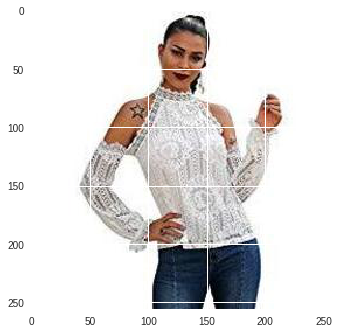

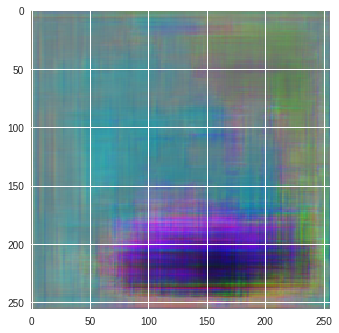

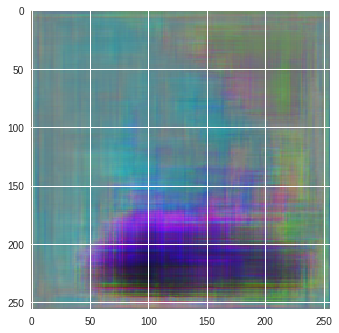





Round 51:
D Real: 0.1265161
D Fake: 0.057243735
G All:: 3.1517391




Round 52:
D Real: 0.039043896
D Fake: 0.06457263
G All:: 3.6820092




Round 53:
D Real: 0.09920753
D Fake: 0.08032061
G All:: 3.6380923




Round 54:
D Real: 0.062385507
D Fake: 0.04407974
G All:: 3.9542253




Round 55:
D Real: 0.04815963
D Fake: 0.040071387
G All:: 4.7967362




Round 56:
D Real: 0.043935664
D Fake: 0.03403458
G All:: 5.1870956




Round 57:
D Real: 0.032707717
D Fake: 0.034889057
G All:: 5.4931736




Round 58:
D Real: 0.049850736
D Fake: 0.030074835
G All:: 5.3942804




Round 59:
D Real: 0.03581946
D Fake: 0.034730986
G All:: 5.7774935




Round 60:
D Real: 0.053805426
D Fake: 0.03973961
G All:: 5.6778936




Round 61:
D Real: 0.035091326
D Fake: 0.037511118
G All:: 5.5161033




Round 62:
D Real: 0.040857904
D Fake: 0.045830913
G All:: 5.277731




Round 63:
D Real: 0.05287371
D Fake: 0.040867727
G All:: 5.3430667




Round 64:
D Real: 0.046430692
D Fake: 0.031713054
G All:: 4.890928




R

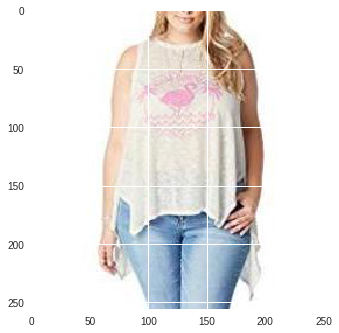

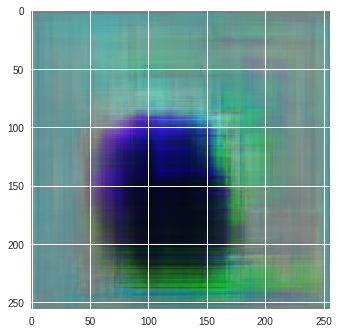

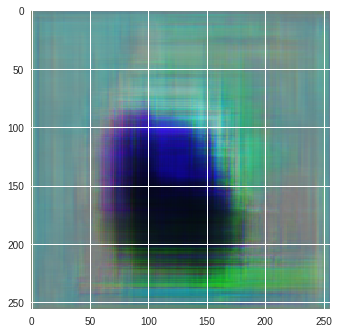





Round 101:
D Real: 0.4531268
D Fake: 0.09390357
G All:: 3.9361043




Round 102:
D Real: 0.6914435
D Fake: 0.26245993
G All:: 2.8608885




Round 103:
D Real: 0.27555588
D Fake: 0.5087843
G All:: 2.260561




Round 104:
D Real: 0.17395005
D Fake: 0.3630875
G All:: 3.3087049




Round 105:
D Real: 0.16245222
D Fake: 0.07174214
G All:: 4.6127234




Round 106:
D Real: 0.17991787
D Fake: 0.040622883
G All:: 5.1298695




Round 107:
D Real: 0.4603241
D Fake: 0.036736883
G All:: 4.406931




Round 108:
D Real: 0.11017896
D Fake: 0.0474409
G All:: 3.1968722




Round 109:
D Real: 0.034237232
D Fake: 0.11126852
G All:: 2.9539547




Round 110:
D Real: 0.048987318
D Fake: 0.18912761
G All:: 3.5648208




Round 111:
D Real: 0.04504924
D Fake: 0.08463363
G All:: 4.70969




Round 112:
D Real: 0.74251735
D Fake: 0.040743724
G All:: 5.3386326




Round 113:
D Real: 0.04198762
D Fake: 0.043698132
G All:: 5.790999




Round 114:
D Real: 0.31619108
D Fake: 0.043183032
G All:: 5.5933285




Round 

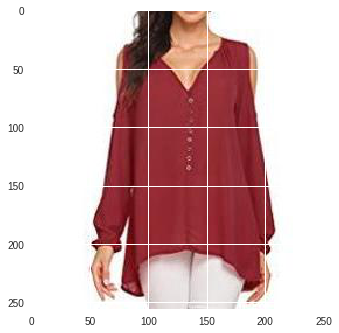

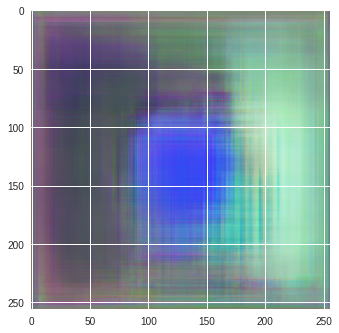

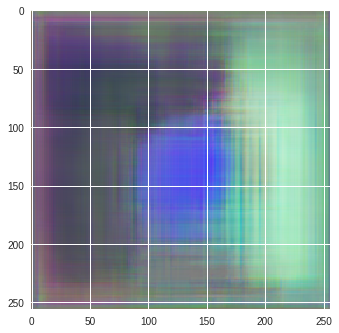





Round 151:
D Real: 0.067324534
D Fake: 0.03953263
G All:: 3.480856




Round 152:
D Real: 0.05700299
D Fake: 0.048251312
G All:: 3.4045532




Round 153:
D Real: 0.032951087
D Fake: 0.1021238
G All:: 4.306807




Round 154:
D Real: 0.061434686
D Fake: 0.041204114
G All:: 5.0128126




Round 155:
D Real: 0.037707612
D Fake: 0.03418287
G All:: 5.1690116




Round 156:
D Real: 0.039296765
D Fake: 0.050585248
G All:: 5.842043




Round 157:
D Real: 0.077365816
D Fake: 0.029359614
G All:: 6.4336658




Round 158:
D Real: 0.06075022
D Fake: 0.024229122
G All:: 6.016548




Round 159:
D Real: 0.03824629
D Fake: 0.03863392
G All:: 6.3358383




Round 160:
D Real: 0.04879056
D Fake: 0.040715925
G All:: 5.711758




Round 161:
D Real: 0.05647362
D Fake: 0.03707156
G All:: 5.434111




Round 162:
D Real: 0.059678514
D Fake: 0.036641143
G All:: 4.9999547




Round 163:
D Real: 0.05077628
D Fake: 0.037870497
G All:: 5.2542887




Round 164:
D Real: 0.05247416
D Fake: 0.05228247
G All:: 4.569097

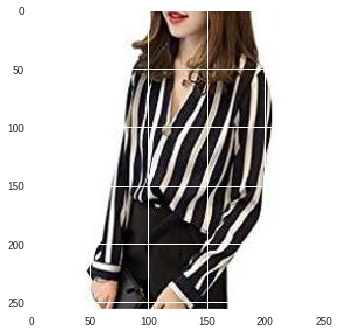

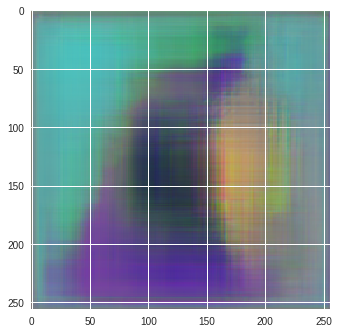

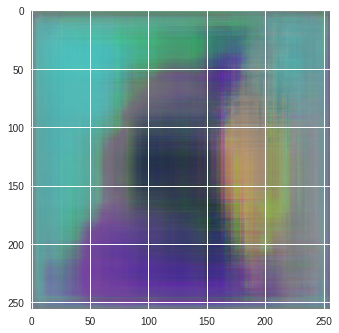





Round 201:
D Real: 0.02832516
D Fake: 0.046819016
G All:: 6.0114536




Round 202:
D Real: 0.03818579
D Fake: 0.039343994
G All:: 6.21692




Round 203:
D Real: 0.056723475
D Fake: 0.041197818
G All:: 6.1443005




Round 204:
D Real: 0.030164383
D Fake: 0.039033383
G All:: 6.6647606




Round 205:
D Real: 0.06330821
D Fake: 0.051275957
G All:: 5.9544306




Round 206:
D Real: 0.15419906
D Fake: 0.028411672
G All:: 5.6990976




Round 207:
D Real: 0.041409113
D Fake: 0.04006812
G All:: 5.6581125




Round 208:
D Real: 0.049200945
D Fake: 0.06808318
G All:: 5.7814493




Round 209:
D Real: 0.03804139
D Fake: 0.036479145
G All:: 5.3420935




Round 210:
D Real: 0.055865306
D Fake: 0.06687954
G All:: 5.630159




Round 211:
D Real: 0.036316793
D Fake: 0.07755703
G All:: 5.9095035




Round 212:
D Real: 0.037067384
D Fake: 0.03702169
G All:: 6.7063713




Round 213:
D Real: 0.19506279
D Fake: 0.033032723
G All:: 6.033482




Round 214:
D Real: 0.05226634
D Fake: 0.058884546
G All:: 5.60

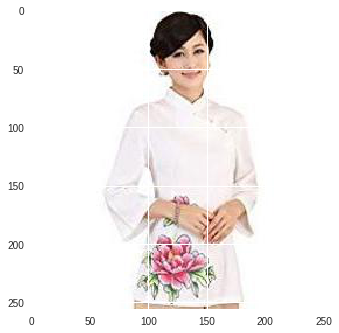

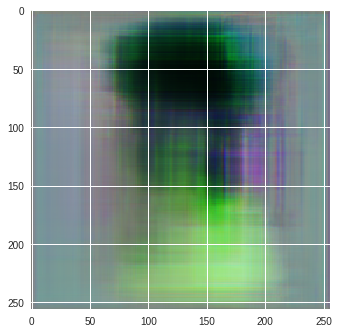

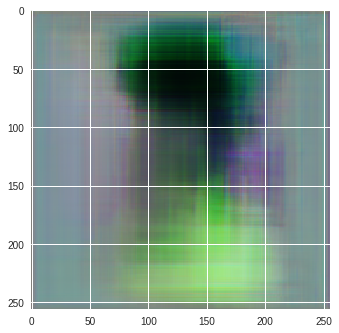





Round 251:
D Real: 1.1431963
D Fake: 0.047322586
G All:: 1.7993205




Round 252:
D Real: 0.047857374
D Fake: 0.64976823
G All:: 1.8808804




Round 253:
D Real: 0.04621534
D Fake: 0.20266138
G All:: 4.779788




Round 254:
D Real: 0.052174013
D Fake: 0.017397046
G All:: 8.037391




Round 255:
D Real: 0.12009817
D Fake: 0.04459714
G All:: 9.864481




Round 256:
D Real: 0.046265658
D Fake: 0.055438805
G All:: 10.618933




Round 257:
D Real: 0.3551231
D Fake: 0.035397723
G All:: 10.783497




Round 258:
D Real: 0.3607074
D Fake: 0.050458323
G All:: 9.175699




Round 259:
D Real: 0.45198652
D Fake: 0.044971537
G All:: 7.162223




Round 260:
D Real: 0.04540679
D Fake: 0.031530183
G All:: 5.081564




Round 261:
D Real: 0.056589894
D Fake: 0.2484597
G All:: 3.971177




Round 262:
D Real: 0.033135146
D Fake: 0.21117677
G All:: 3.6906343




Round 263:
D Real: 0.049081247
D Fake: 0.10107987
G All:: 5.041916




Round 264:
D Real: 0.047523532
D Fake: 0.040086716
G All:: 6.1712666





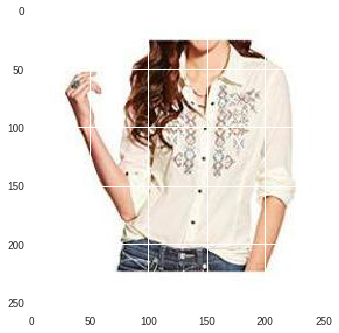

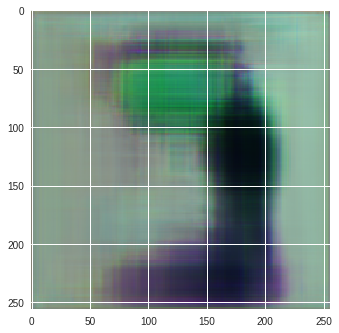

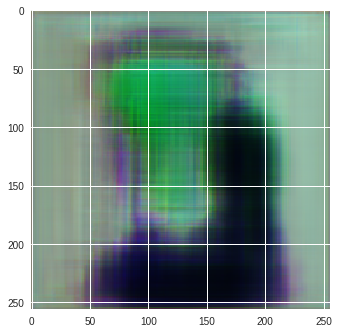





Round 301:
D Real: 0.049915057
D Fake: 0.06515862
G All:: 3.7682858




Round 302:
D Real: 0.034418467
D Fake: 0.041935872
G All:: 3.884307




Round 303:
D Real: 0.042571366
D Fake: 0.05779588
G All:: 3.689088




Round 304:
D Real: 0.068504125
D Fake: 0.09525317
G All:: 4.2931614




Round 305:
D Real: 0.04732544
D Fake: 0.033687398
G All:: 4.297683




Round 306:
D Real: 0.037236575
D Fake: 0.049123086
G All:: 4.1653223




Round 307:
D Real: 0.29164463
D Fake: 0.07566008
G All:: 3.0995271




Round 308:
D Real: 0.03302197
D Fake: 0.32468766
G All:: 3.9771607




Round 309:
D Real: 0.09846821
D Fake: 0.0586524
G All:: 5.408537




Round 310:
D Real: 0.88468814
D Fake: 0.31561556
G All:: 5.652957




Round 311:
D Real: 0.048881337
D Fake: 0.12494551
G All:: 6.2055087




Round 312:
D Real: 0.21284539
D Fake: 0.041108973
G All:: 6.8210106




Round 313:
D Real: 0.049487315
D Fake: 0.034710545
G All:: 6.0418997




Round 314:
D Real: 0.56792337
D Fake: 0.1083648
G All:: 3.6245599



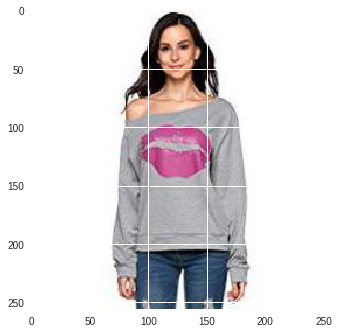

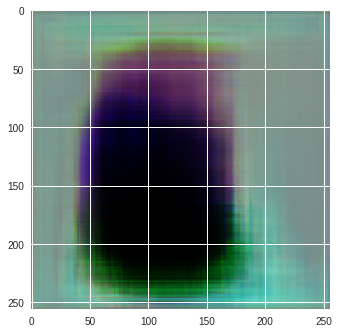

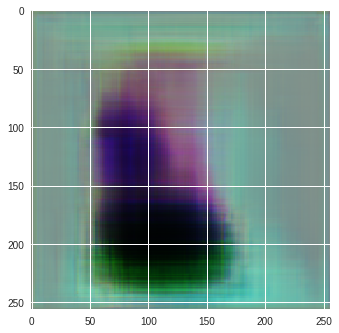





Round 351:
D Real: 0.3727377
D Fake: 0.05409995
G All:: 5.917305




Round 352:
D Real: 0.30358636
D Fake: 0.11968318
G All:: 4.437435




Round 353:
D Real: 0.06889711
D Fake: 0.02669844
G All:: 4.076448




Round 354:
D Real: 0.0802857
D Fake: 0.14658792
G All:: 2.8458617




Round 355:
D Real: 0.037962865
D Fake: 1.66698
G All:: 4.22214




Round 356:
D Real: 0.29711145
D Fake: 0.03143484
G All:: 7.152706




Round 357:
D Real: 0.032665327
D Fake: 0.04381647
G All:: 6.554258




Round 358:
D Real: 0.08278236
D Fake: 0.050093956
G All:: 7.036668




Round 359:
D Real: 1.3530151
D Fake: 0.11653237
G All:: 6.103454




Round 360:
D Real: 0.11129916
D Fake: 0.13658954
G All:: 5.0290794




Round 361:
D Real: 0.2967743
D Fake: 0.07724653
G All:: 3.0803099




Round 362:
D Real: 0.092011794
D Fake: 0.5336446
G All:: 2.166051




Round 363:
D Real: 0.043274418
D Fake: 0.48195803
G All:: 2.6953576




Round 364:
D Real: 0.049692363
D Fake: 0.06590779
G All:: 3.9480445




Round 365:
D R

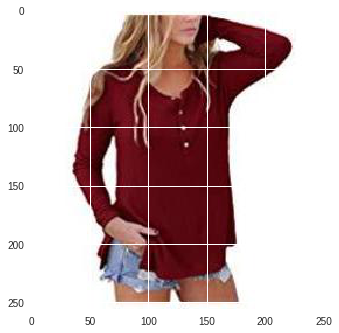

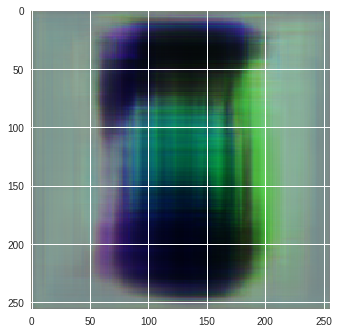

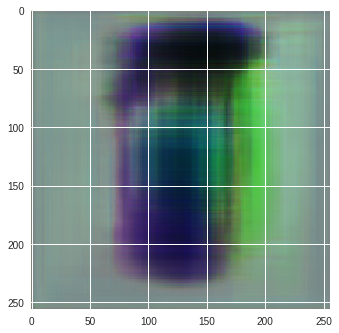





Round 401:
D Real: 0.30294648
D Fake: 0.20978484
G All:: 2.9231632




Round 402:
D Real: 0.08857663
D Fake: 0.42021567
G All:: 2.9773684




Round 403:
D Real: 0.042651974
D Fake: 0.15974501
G All:: 4.9776745




Round 404:
D Real: 0.03373907
D Fake: 0.1415728
G All:: 6.680151




Round 405:
D Real: 0.15627335
D Fake: 0.05930291
G All:: 7.0317326




Round 406:
D Real: 0.60380244
D Fake: 0.023704045
G All:: 5.975023




Round 407:
D Real: 0.7458754
D Fake: 0.085976645
G All:: 4.374053




Round 408:
D Real: 0.33443946
D Fake: 0.26828444
G All:: 2.8596137




Round 409:


KeyboardInterrupt: ignored

In [2]:
#if training new model:
model = Model_GAN() 

print("We're off! See you in a while!")

while(model.GAN.steps < 500000):
    
    print("\n\n\n\nRound " + str(model.GAN.steps) + ":")
    model.train()
    
    if model.GAN.steps % 1000 == 0:
        model.eval2(int(model.GAN.steps / 1000))

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Sprites.zip to Sprites (1).zip


In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['Sprites.zip']), 'r')
data.extractall()

In [0]:
data.printdir()

In [0]:
os.listdir('Sprites')

In [0]:
os.mkdir('Results_Pokemon')

In [0]:
model.eval2()

In [0]:
os.mkdir('Models')

In [0]:
model.save(2)